# Obtain detuning from FID

In [519]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas as pd
import numpy as np
from pathlib import Path

#absolute path of repo root
rel_path = Path("/home/ben/Documents/Repos/382L_NMRLab/")

In [585]:
omega = 647
FIDData = pd.read_csv(rel_path / f"data/FID_resonance/{str(omega)}.csv")
buffer = 50
cutoff = np.argmax(np.diff(FIDData["v1"]))+buffer

In [619]:
#trim out saturated data
chan1 = FIDData["v1"][cutoff:].values
chan2 = FIDData["v2"][cutoff:].values
tlist = FIDData["t"][cutoff:].values

#adjust y axis (needed for getting maxima by squaring)
chan1 = np.subtract(chan1, np.mean(chan1[1500:]))
chan2 = np.subtract(chan2, np.mean(chan1[1500:]))

#tstep is 2e-6 (units of seconds)
tstep = tlist[1]-tlist[0]

In [620]:
def smooth(y, pts): #Rolling avg smoothing
    box = np.ones(pts)/pts
    yfilt=np.convolve(y,box,mode='same')
    return yfilt

In [621]:
chan1_smooth = smooth(chan1, 40)
chan2_smooth = smooth(chan2, 40)

## Find zeros

In [622]:
def next_zero(arr, start):
    for i in range(start,len(arr)-1):
        if not (np.sign(arr[i]) == np.sign(arr[i+1])):
            return i
    
def zeros(ydata, min_spacing):
    zeros = []
    new_zero = -min_spacing
    for i in range(7):
        new_zero = next_zero(ydata, new_zero+min_spacing)
        zeros.append(new_zero)
    return zeros

In [623]:
zeros1 = zeros(chan1_smooth, 10)
zeros2 = zeros(chan2_smooth, 10)

spacing = zeros1[1]-zeros1[0]

zeros1 = zeros(chan1_smooth, round(spacing*1.5))
zeros2 = zeros(chan2_smooth, round(spacing*1.5))

Text(0, 0.5, 'Voltage (V)')

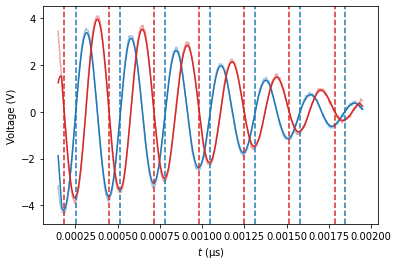

In [624]:
plt.plot(tlist, chan1, color = "tab:blue", alpha = .4)
plt.plot(tlist, chan1_smooth, color = "tab:blue")
plt.plot(tlist, chan2, color = "tab:red", alpha = .4)
plt.plot(tlist, chan2_smooth, color = "tab:red")
for zero in zeros1:
    plt.axvline(tlist[zero], color = "tab:blue", linestyle = "--")
for zero in zeros2:
    plt.axvline(tlist[zero], color = "tab:red", linestyle = "--")

plt.xlabel(r"$t$ (μs)")
plt.ylabel("Voltage (V)")

In [599]:
spacing1 = np.mean(np.diff(zeros1))
spacing2 = np.mean(np.diff(zeros2))
spacing = np.mean([spacing1, spacing2])
## Detuning (Hz)
delta_omega = 1/(spacing*tstep)

In [600]:
#Resonant frequency
omega_0 = omega + delta_omega
print(omega_0)

6476762.935089369


## Automatic processing

In [574]:
freq_data = {}
omegas = list(sorted([int(f.stem) for f in (rel_path / "data/FID_resonance/").iterdir()]))

def get_detuning(omega):

    FIDData = pd.read_csv(rel_path / f"data/FID_resonance/{str(omega)}.csv")
    buffer = 200
    cutoff = np.argmax(np.diff(FIDData["v1"]))+buffer
    #trim out saturated data
    chan1 = FIDData["v1"][cutoff:].values
    chan2 = FIDData["v2"][cutoff:].values
    tlist = FIDData["t"][cutoff:].values

    #adjust y axis (needed for getting maxima by squaring)
    chan1 = np.subtract(chan1, np.mean(chan1[cutoff:]))
    chan2 = np.subtract(chan2, np.mean(chan1[cutoff:]))

    #tstep is 2e-6 (units of seconds)
    tstep = tlist[1]-tlist[0]

    chan1_smooth = smooth(chan1, 10)
    chan2_smooth = smooth(chan2, 10)

    zeros1 = zeros(chan1_smooth, 1)
    zeros2 = zeros(chan2_smooth, 1)

    spacing = zeros1[1]-zeros1[0]

    zeros1 = zeros(chan1_smooth, round(spacing*1.5))
    zeros2 = zeros(chan2_smooth, round(spacing*1.5))

    spacing = np.mean([zeros1[1]-zeros1[0], zeros2[1]-zeros2[0]])
    return 1/(spacing*tstep)

In [575]:
for omega in omegas:
    freq_data[omega] = get_detuning(omega)

In [576]:
freq_data

{6473000: 3752.3452157597585,
 6474000: 2762.430939226452,
 6475000: 1730.1038062284254,
 6478000: 1199.040767386062,
 6479000: 2224.694104560689}

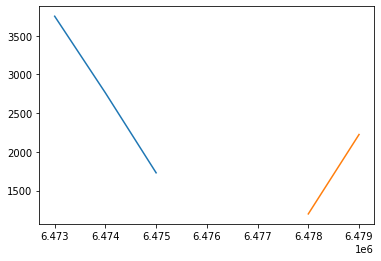

In [605]:
plt.plot(list(freq_data.keys())[:3], list(freq_data.values())[:3])
plt.plot(list(freq_data.keys())[3:], list(freq_data.values())[3:])

In [607]:
linear = lambda x,b : np.abs(x-b)
popt, pcov = sc.optimize.curve_fit(linear, list(freq_data.keys()), list(freq_data.values()))

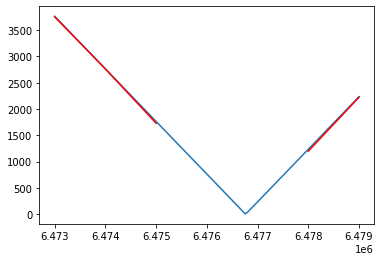

In [611]:
xlist = np.linspace(min(freq_data.keys()), max(freq_data.keys()), 100)
plt.plot(xlist, [linear(x, *popt) for x in xlist])
plt.plot(list(freq_data.keys())[:3], list(freq_data.values())[:3], color = "red")
plt.plot(list(freq_data.keys())[3:], list(freq_data.values())[3:], color = "red")

In [612]:
popt[0]

6476764.229017855

In [615]:
np.sqrt(pcov.item())

11.791509196880014